# Can Machine Learning Identify Liquid Crystal Phases

## Cholesteric or Nematic binary image classification
### via transfer learning

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from PIL import Image
from skimage.color import rgb2gray
from skimage.transform import resize

### 1. Retrieving data and image preprocessing

In [2]:
directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Nematic-Cholesteric-balanced-24-10-20"

train_dir = directory + "/Training"
val_dir = directory + "/Validation"
test_dir = directory + "/Test"

In [5]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 45,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True
                                  )
val_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = "binary",
                                                    target_size = (200, 200)
                                                   )
val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size = 64,
                                                class_mode = "binary",
                                                target_size = (200,200)
                                               )
test_generator = val_datagen.flow_from_directory(test_dir,
                                                batch_size = 64,
                                                class_mode = "binary",
                                                target_size = (200,200)
                                               )

Found 870 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 137 images belonging to 2 classes.


### 2. Defining the model

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = "imagenet"
                               )

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 99, 99, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 99, 99, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [23]:
last_layer = pre_trained_model.get_layer("mixed7")
print('last layer output shape: ' + str(last_layer.output_shape))
last_output = last_layer.output

last layer output shape: (None, 10, 10, 768)


In [25]:
x = layers.Flatten()(last_output)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x) 

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 99, 99, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 99, 99, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

## 3. Fitting the model

In [26]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model_save_dir = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Cholesteric-Nematic-transfer_learning-saved"
checkpoint = ModelCheckpoint(model_save_dir, monitor = "val_accuracy", save_best_only = True, mode="max")
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    callbacks=[checkpoint],
                    verbose=2
                   )

Epoch 1/20
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)\Cholesteric-Nematic-transfer_learning-saved\assets
14/14 - 49s - loss: 0.7992 - accuracy: 0.7517 - val_loss: 0.0929 - val_accuracy: 0.9722
Epoch 2/20
INFO:tensorflow:Assets written to: C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)\Cholesteric-Nematic-transfer_learning-saved\assets
14/14 - 49s - loss: 0.2257 - accuracy: 0.9034 - val_loss: 0.0521 - val_accuracy: 0.9931
Epoch 3/20
14/14 - 34s - loss: 0.1304 - accuracy: 0.9483 - val_loss: 0.0772 - val_accuracy: 0.9861
Epoch 4/20
14/14 - 39s - loss: 0.1186 - accuracy: 0.9575 - val_loss: 0.0528 - val_accuracy: 0.9861
Epoch 5/20
14/14 - 38s - loss: 0.0602 - accuracy: 0.9782 - val_loss: 0.0680 - 

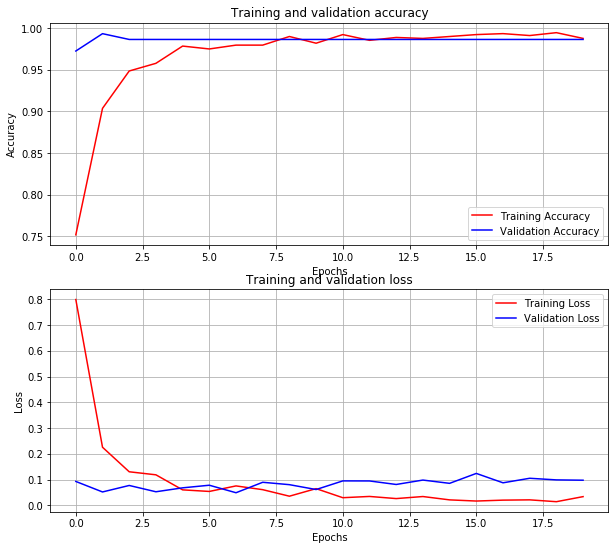

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10,9))

plt.subplot(2,1,1)
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("Cholesteric-Nematic-transfer_learning-train_val_graph")
plt.show()

## 5.Testing trained model

In [29]:
trained_model = tf.keras.models.load_model(model_save_dir)

for layer in trained_model.layers:
  layer.trainable = False

trained_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 99, 99, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 99, 99, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [30]:
test_loss, test_acc = trained_model.evaluate(test_generator, verbose=2)

3/3 - 2s - loss: 0.0739 - accuracy: 0.9854


In [93]:
#outputs prediction for image file and associated confidence
def predict_image(filename, model):

    image = transform_image(Image.open(filename), as_array=True)
    plt.imshow(image)
    plt.show()
    
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, steps=1, verbose=1)
    pred_class = np.array([prediction > 0.5])
    
    print('Predicted phase:')
    
    if pred_class[0] == 0:
        print('cholesteric')
        print('Confidence level:')
        print(1 - prediction[0][0])
    elif pred_class[0] == 1:
        print('nematic')
        print('Confidence level:')
        print(prediction[0][0])

        
    return (pred_class[0], prediction[0])

In [100]:
def transform_image(image, as_array=False, size=200, black_and_white=False):
    img = np.array(image)

    height = np.shape(img)[0]
    width = np.shape(img)[1]
    square = (height == width)
    
    #if image is not square, crop excess height/width
    if not square:
        diff = height - width
        crop = int(np.abs(diff) / 2)
        
        if diff > 0:
            img = img[crop:width+crop, :]
        else:
            img = img[:, crop:height+crop]
    
    if black_and_white:
        img = rgb2gray(img)
        
    img = resize(img, (size, size), anti_aliasing=False)[:,:,:3]
    img *= 255
    img = img.astype(np.uint8)
    
    if as_array:
        return img
    
    return Image.fromarray(img)

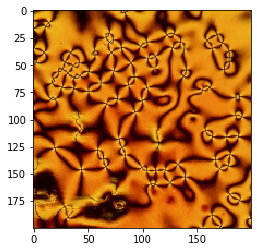

(1, 200, 200, 3)
1/1 [==============================] - 0s 9ms/step
Predicted phase:
cholesteric
Confidence level:
1.0


In [113]:
img_dir = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning"
image_path = img_dir + "/Images_Vance_Williams_IG/Nematic_Vance_Williams_IG(7).jpg"
#image_path = img_dir + "/Nematic-Cholesteric-balanced-24-10-20/Test/Nematic/f00251.png"

label, confidence = predict_image(image_path, trained_model)